In [1]:
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np

# Install the following two modules first if you ecounter ModuleNotFoundError by doing pip
# !pip install umap-learn
# !pip install hdbscan

from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

import MDAnalysis as mda
from MDAnalysis.analysis import pca
from MDAnalysis.analysis.align import rotation_matrix


In [2]:
structure = "/Users/k20098771/Data/2024/CG_Simulation/Group_1/AF_WT_CG_step6_6.tpr"
trajectory = "/Users/k20098771/Data/2024/CG_Simulation/Group_1/AF_WT_CG_200us_100000dt_centered.xtc"
title="AF_WT_All"

In [3]:
output_dir = "./AF_WT/AF_WT_All"
Path(output_dir).mkdir(parents=True, exist_ok=True)

## Load traj and select atoms

In [4]:
u = mda.Universe(structure, trajectory)

In [5]:
# use all frames in the trajectory
start, stop, step = u.trajectory.check_slice_indices(None, None, None)
frames = np.arange(start, stop, step)
n_frames = frames.size

In [6]:
print ("frame=",n_frames)

frame= 2001


In [7]:
backbone = u.select_atoms("name BB")

In [8]:
backbone

<AtomGroup with 112 atoms>

# Calculate Distance Matrix

In [9]:
u_1000 = u.trajectory
len(u_1000)
time=[]
for ts in tqdm(u_1000):
    time.append(u.trajectory.time)
time=np.array(time)
len(time)

  0%|          | 0/2001 [00:00<?, ?it/s]

2001

In [10]:
# #Select DAP12 and TREM2
# DAP12_A = u.select_atoms('index 0:63 and name BB') #DAP12 chain A
# DAP12_B = u.select_atoms('index 64:127 and name BB') #DAP12 chain B
# TREM2 = u.select_atoms('index 12a8:226 and name BB') #TREM2

# print(np.unique(DAP12_A.resids))
# print(np.unique(DAP12_B.resids))
# print(np.unique(TREM2.resids))

In [11]:
# #Selection of DAP12 and TREM2 key residues
DAP12_A = u.select_atoms('index 19 26 34 40 42 46 and name BB') #DAP12 chain A I12, D16, T20, I23, A24, V27
DAP12_B = u.select_atoms('index 83 90 98 104 106 110 and name BB') #DAP12 chain B I12, D16, T20, I23, A24, V27
TREM2 = u.select_atoms('index 166 181 195 and name BB') #TREM2 L19, K26, W34
print(np.unique(DAP12_A.resids))
print(np.unique(DAP12_B.resids))
print(np.unique(TREM2.resids))

[12 16 20 23 24 27]
[45 49 53 56 57 60]
[ 85  92 100]


In [12]:
# Initialize lists to store distances
distances_A = []

# Iterate over trajectory frames
for ts in tqdm(u_1000, total=len(u_1000)):
    # Calculate distances between DAP12_A and TREM2 for the current frame
    distances_A_frame = mda.lib.distances.distance_array(DAP12_A.positions, TREM2.positions)
    distances_A.append(distances_A_frame)
    
# Convert distance lists to numpy arrays
distances_A = np.array(distances_A)

  0%|          | 0/2001 [00:00<?, ?it/s]

In [13]:
# Initialize lists to store distances
distances_B = []

# Iterate over trajectory frames
for ts in tqdm(u_1000, total=len(u_1000)):
    # Calculate distances between DAP12_A and TREM2 for the current frame
    distances_B_frame = mda.lib.distances.distance_array(DAP12_B.positions, TREM2.positions)
    distances_B.append(distances_B_frame)
    
# Convert distance lists to numpy arrays
distances_B = np.array(distances_B)

  0%|          | 0/2001 [00:00<?, ?it/s]

In [14]:
distances_A.shape

(2001, 6, 3)

In [15]:
# Reshape all_pos to a two-dimensional array
# flattened_pos = all_pos.reshape(-1, all_pos.shape[-1]) #(n_frames * n_atoms, n_dimensions)
flattened_pos_A = distances_A.reshape(distances_A.shape[0], -1) #(n_frames, n_atoms * n_dimensions)
flattened_pos_B = distances_B.reshape(distances_B.shape[0], -1)

In [16]:
flattened_pos_A.shape

(2001, 18)

In [17]:
# Merge the arrays
merged_array = np.hstack((flattened_pos_A, flattened_pos_B))

In [18]:
merged_array.shape

(2001, 36)

In [19]:
column_variances = np.var(merged_array, axis=0)

In [20]:
column_variances.shape

(36,)

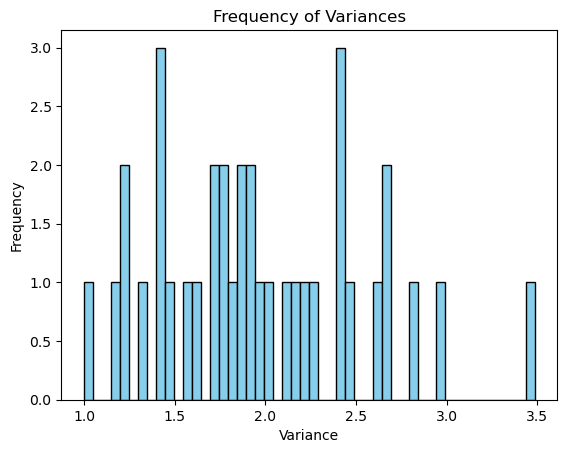

In [21]:
# Step 2: Plot the frequency of variances
plt.hist(column_variances, bins=50, color='skyblue', edgecolor='black')
plt.title('Frequency of Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

In [22]:
# Step 2: Filter out columns with non-unique variances
unique_variances, unique_indices = np.unique(column_variances, return_index=True)
filtered_columns = []

for variance, index in zip(unique_variances, unique_indices):
    if variance >= 1:  # Only include columns with variance >= 10
        filtered_columns.append(merged_array[:, index])

# Convert the list of filtered columns to a numpy array
filtered_dataset = np.column_stack(filtered_columns)

In [23]:
# Check the dimensions of the filtered dataset
print("Filtered dataset dimensions:", filtered_dataset.shape)

Filtered dataset dimensions: (2001, 35)


In [24]:
filtered_dataset

array([[15.64896293,  7.51664956,  9.26822385, ..., 12.26621701,
         7.79999748,  9.7272837 ],
       [13.97605408,  9.60312339, 11.1579487 , ..., 17.15605   ,
         9.66384951,  7.26979908],
       [14.92280419,  9.19456247, 12.97073066, ..., 13.96638917,
        11.32210883,  6.02411784],
       ...,
       [16.68921999, 10.87290144,  7.87782159, ..., 14.6989843 ,
         7.95110411,  9.06752385],
       [15.15288685, 10.18086395,  8.33186719, ..., 14.82632876,
         7.94355003,  9.3268432 ],
       [15.87513537,  9.89848284,  7.04982432, ..., 14.37706279,
         7.57231813,  8.6377058 ]])

In [25]:
# max_values_per_row = np.amax(filtered_dataset, axis=1)
max_values_per_column = np.amax(filtered_dataset, axis=0)

In [26]:
max_values_per_column

array([20.33936475, 12.63369055, 12.97073066, 16.81933523, 13.07669701,
       16.73977612, 26.41476359, 16.08010791, 16.66072939, 24.54973784,
       17.33926236, 16.95553051, 20.23116474, 15.58235858, 25.10737221,
       30.26234586, 18.15984957, 22.41182159, 30.20033521, 25.3838584 ,
       21.04400176, 21.10402657, 28.1449826 , 20.54117944, 12.60673844,
       15.6744986 , 14.43814497, 27.64670502, 15.7996818 , 12.47638415,
       16.93546862, 16.14589959, 17.82638412, 17.5909061 , 13.96639337])

In [27]:
max_values_per_column.shape

(35,)

In [28]:
# Normalize each column by dividing by the corresponding maximum value
# normalized_array = filtered_dataset / max_values_per_row[:, np.newaxis]
normalized_array = filtered_dataset / max_values_per_column[np.newaxis, :]

In [29]:
normalized_array.shape

(2001, 35)

In [30]:
normalized_array

array([[0.7693929 , 0.59496863, 0.71454909, ..., 0.68809339, 0.44341078,
        0.69647786],
       [0.6871431 , 0.7601202 , 0.86024057, ..., 0.96239652, 0.54936622,
        0.52052086],
       [0.73369077, 0.7277812 , 1.        , ..., 0.78346731, 0.6436342 ,
        0.43132953],
       ...,
       [0.82053792, 0.86062749, 0.60735373, ..., 0.82456342, 0.45200083,
        0.64923876],
       [0.74500296, 0.80585035, 0.64235912, ..., 0.83170702, 0.4515714 ,
        0.66780614],
       [0.78051284, 0.78349891, 0.5435179 , ..., 0.80650471, 0.43046777,
        0.61846359]])

In [31]:
all_pos = normalized_array

In [32]:
all_pos.shape

(2001, 35)

## First find mean structure 

In [33]:
# first_pos = backbone.unwrap()
# first_pos -= np.mean(first_pos, axis=0)

In [34]:
# all_pos = np.full((n_frames, backbone.n_atoms, 3), fill_value=np.NaN)

In [35]:
# all_pos.shape

In [36]:
# for frame_index, ts in tqdm(enumerate(u.trajectory[frames]), total=n_frames):
    
#     backbone.unwrap(inplace=True)
#     backbone.translate(-backbone.center_of_mass())
#     R, rmsd = rotation_matrix(backbone.positions, first_pos)
#     backbone.rotate(R)
#     all_pos[frame_index] = backbone.positions
    

In [37]:
# ref_pos = np.mean(all_pos, axis=0)

## Get atom positions of the backbone at each frame

In [38]:
# all_pos = np.full((n_frames, backbone.n_atoms * 3), fill_value=np.NaN)

In [39]:
# all_pos.shape

In [40]:
# # align to references structure (mean atom positions)
# for frame_index, ts in tqdm(enumerate(u.trajectory[frames]), total=n_frames):
    
#     backbone.unwrap(inplace=True)
#     backbone.translate(-backbone.center_of_mass())
#     R, rmsd = rotation_matrix(backbone.positions, ref_pos)
#     backbone.rotate(R)
#     all_pos[frame_index] = backbone.positions.ravel()


## Now run umap on these positions

In [41]:
ss = StandardScaler()
scaled_pos = ss.fit_transform(all_pos)

In [42]:
X_embedded = umap.UMAP(
    n_neighbors=10,  # larger numbers forcus more on global properties (and increase computational effort required)
    n_components=2,  # set the number of dimensions to reduce to
    min_dist=0.0,    # must be 0.0 if points are to be clustered later with HDBSCAN
    verbose=True,
    n_jobs=1,        # use all available cores
    random_state=100
).fit_transform(all_pos)

UMAP(min_dist=0.0, n_jobs=1, n_neighbors=10, random_state=100, verbose=True)
Mon Jun 10 15:18:00 2024 Construct fuzzy simplicial set


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Mon Jun 10 15:18:01 2024 Finding Nearest Neighbors
Mon Jun 10 15:18:02 2024 Finished Nearest Neighbor Search
Mon Jun 10 15:18:03 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 10 15:18:05 2024 Finished embedding


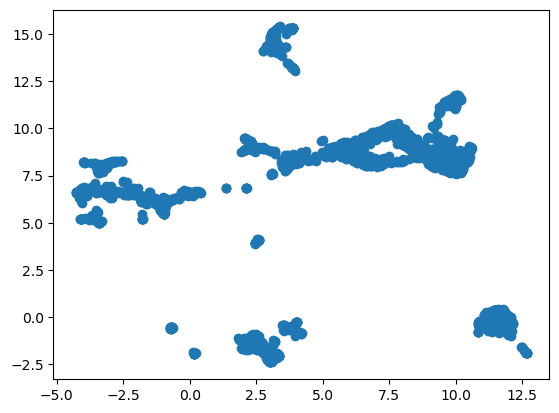

In [43]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])

## Cluster with HDBSCAN

In [44]:
hdb = hdbscan.HDBSCAN(
    min_cluster_size=50,              # minimum number of points for a group to be considered a cluster
    cluster_selection_epsilon=1.0,      # clusters closer than this distance apart will be merged
    cluster_selection_method="leaf"   # changes the way clusters are initialised. "eom" tends to lead to fewer clusters than "leaf"
)

hdb.fit(X_embedded)

y_pred = hdb.fit_predict(X_embedded)

## How many points are "noise"? i.e. not assigned to a cluster

In [45]:
print(f"Not in a cluster: {sum(y_pred==-1)} ({100 * sum(y_pred==-1) / y_pred.size:.2f}%)")

Not in a cluster: 0 (0.00%)


## Check out how well the clusters are separated

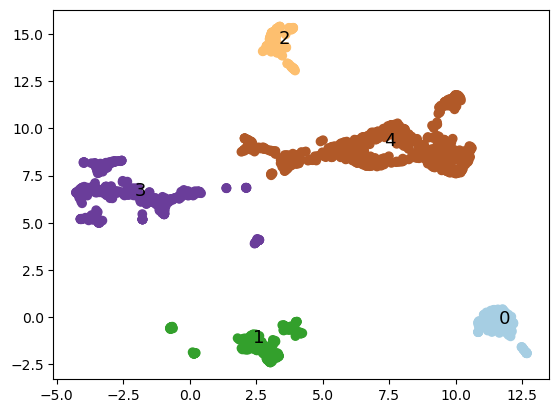

In [46]:
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=y_pred, cmap='Paired')

for cluster in range(max(y_pred)+1):    
    mean = np.mean(X_embedded[y_pred==cluster], axis=0)
    plt.text(
        mean[0], mean[1],
        cluster,
        fontsize=13
    )
    

## And the time evolution of cluster number

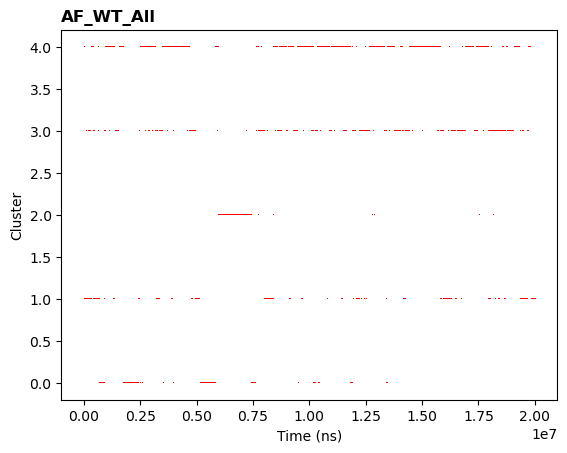

In [47]:
# times = np.arange(u.trajectory.n_frames) / (1000 / u.trajectory.dt)
times_subsampled = np.arange(len(u_1000)) * 100 / (1000 / u.trajectory.dt)
times = times_subsampled

plt.plot(times, y_pred, 'r,')
plt.xlabel("Time (ns)")
plt.ylabel("Cluster")
plt.title(f"{title}", loc="left", weight="bold")

#plt.yticks(np.arange(min(cluster_labels), max(cluster_labels) + 1, 1))

plt.savefig(f"{output_dir}/init_cluster_number_time.png", dpi=400, bbox_inches="tight")

## Arrange clusters in order of when they first appear in the trajectory

In [48]:
unique_clusters, frame_first_seen = np.unique(y_pred, return_index=True)
sorter = np.argsort(frame_first_seen)
cluster_order = unique_clusters[sorter]

cluster_labels = np.full_like(y_pred, fill_value=-1)
index2=0
for index, cluster in enumerate(cluster_order, start=1):
    if cluster == -1:
        cluster_labels[y_pred==cluster] = -1
        continue
    index2+=1
    cluster_labels[y_pred==cluster] = index2
    

In [49]:
u

<Universe with 11320 atoms>

## Replot the clusters with their new labels

1
2
3
4
5


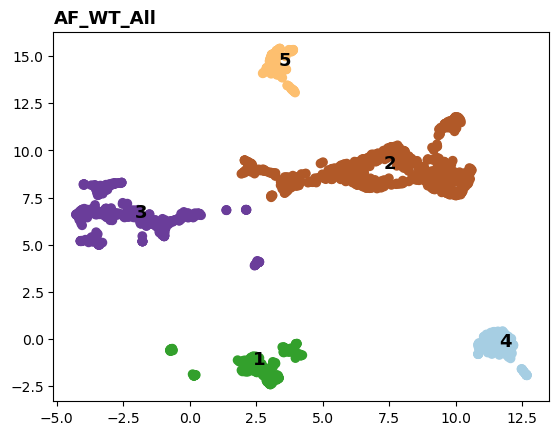

In [50]:
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=y_pred, cmap='Paired')
for cluster in np.unique(cluster_labels):
    print(cluster)
    if cluster == -1:
        continue
    
    mean = np.mean(X_embedded[cluster_labels==cluster], axis=0)
    plt.text(
        mean[0], mean[1],
        cluster,
        fontsize=13,
        weight="bold"
    )

plt.title(f"{title}", loc="left", weight="bold", size=13) 

plt.savefig(f"{output_dir}/clusters.png", dpi=400, bbox_inches="tight")
    
    

## Plot the cluster number over time
Is there a pathway from cluster 1 to n? Or does the peptide switch between states?

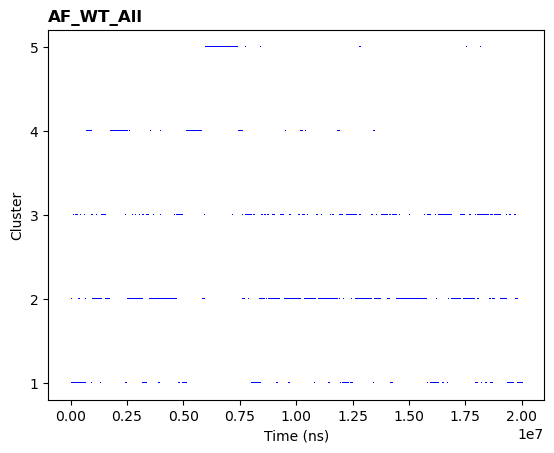

In [51]:
# times = np.arange(u.trajectory.n_frames) / (1000 / u.trajectory.dt)
times_subsampled = np.arange(len(u_1000)) * 100 / (1000 / u.trajectory.dt)
times = times_subsampled

plt.plot(times, cluster_labels, 'b,')

plt.xlabel("Time (ns)")
plt.ylabel("Cluster")
plt.title(f"{title}", loc="left", weight="bold")

plt.yticks(np.arange(min(cluster_labels), max(cluster_labels) + 1, 1))

plt.savefig(f"{output_dir}/clusters-over-all-time.png", dpi=400, bbox_inches="tight")


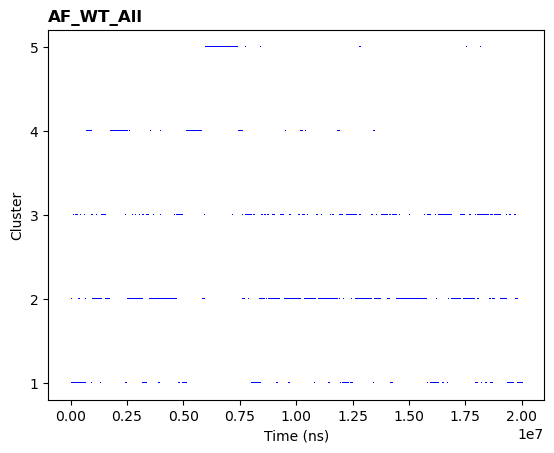

In [52]:
# times = np.arange(u.trajectory.n_frames) / (1000 / u.trajectory.dt)
times_subsampled = np.arange(len(u_1000)) * 100 / (1000 / u.trajectory.dt)
times = times_subsampled

plt.plot(times[-10000:], cluster_labels[-10000:], 'b,')

plt.xlabel("Time (ns)")
plt.ylabel("Cluster")
plt.title(f"{title}", loc="left", weight="bold")

plt.yticks(np.arange(min(cluster_labels), max(cluster_labels) + 1, 1))

plt.savefig(f"{output_dir}/clusters-over-final-time.png", dpi=400, bbox_inches="tight")

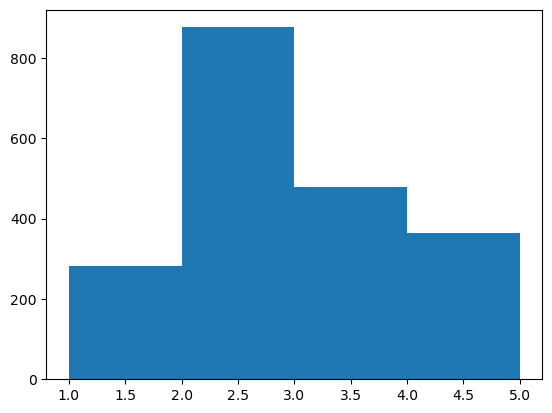

In [53]:
nclusters=max(cluster_labels)-min(cluster_labels)
plt.hist(cluster_labels[-10000:],bins=nclusters)
plt.savefig(f"{output_dir}/cluster-size-final-histo.png")

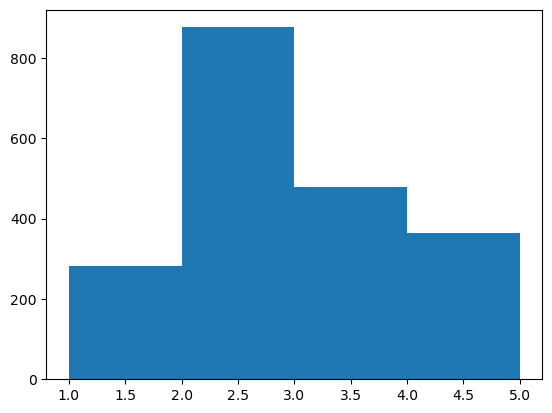

In [54]:
plt.hist(cluster_labels,bins=nclusters)
plt.savefig(f"{output_dir}/cluster-size-all-histo.png")

In [55]:
np.save(f"{output_dir}/cluster-labels.npy", cluster_labels)

# Write a PDB for each cluster

## First identify representative frame for each cluster

In [56]:
all_rep_frame = []
backbone = u.select_atoms("name BB")
for cluster in tqdm(np.unique(cluster_labels)):
    
    # ref structures will be first structure in a cluster 
    first_frame = np.where(cluster_labels==cluster)[0][0]
    u.trajectory[first_frame]
    ref_pos = backbone.unwrap()
    ref_pos -= np.mean(ref_pos, axis=0)
    
    # frames at which cluster is found
    frames = np.where(cluster_labels==cluster)[0]
    n_frames = frames.size
    cluster_pos = np.full((n_frames, backbone.n_atoms, 3), fill_value=np.NaN)
    
    # align all and get positions
    for frame_index, ts in enumerate(u.trajectory[frames]):
        
        backbone.unwrap(inplace=True)
        backbone.translate(-backbone.center_of_mass())
        R, rmsd = rotation_matrix(backbone.positions, ref_pos)
        backbone.rotate(R)
        cluster_pos[frame_index] = backbone.positions

    # find mean position
    mean = np.mean(cluster_pos, axis=0)
    
    # calculate rmsds to mean position
    rmsd = np.mean(np.sum((np.square(cluster_pos - mean)), axis=2), axis=1)
    
    # find frame at which rmsd to mean position is smallest
    rep_frame = np.min(np.where(rmsd==min(rmsd)))
    all_rep_frame.append(rep_frame)
    

  0%|          | 0/5 [00:00<?, ?it/s]

## Now write the PDBs

In [57]:
# Select atoms for writing
atoms = u.select_atoms("protein")

In [58]:
# align to the previous structure
ref_pos = backbone.positions
ref_pos -= np.mean(ref_pos)

for rep_frame, cluster in tqdm(zip(all_rep_frame, np.unique(cluster_labels))):
    
    if cluster == -1:
        continue
    
    # load coordinates from representative frame
    u.trajectory[rep_frame]
    
    # translate and rotate aroms
    atoms.unwrap(inplace=True)
    atoms.translate(-backbone.center_of_mass())
    R, rmsd = rotation_matrix(backbone.positions, ref_pos)
    atoms.rotate(R)

    # write pdb
    atoms.write(f"{output_dir}/cluster_{cluster}.pdb")
    
    # Uncomment to align to clusters sequentially rather than always to cluster 1
    #ref_pos = backbone.positions
    #ref_pos -= np.mean(ref_pos)


0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/mdaenv/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/opt/homebrew/Caskroom/miniconda/base/envs/mdaenv/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/opt/homebrew/Caskroom/miniconda/base/envs/mdaenv/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/opt/homebrew/Caskroom/miniconda/base/envs/mdaenv/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '